# Logging of the project

In this notebook you will find all the steps it took us to accurately predict the temperature of nuclear waste canister. 

### **Imports** 

In [1]:
random_state = 42
## data handling 
import numpy as np
import pandas as pd
import random

## plotting
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Sklearn 
from sklearn.impute import KNNImputer
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
k_fold = KFold(n_splits=8, shuffle=True, random_state=random_state) # can specify a random_state if needed (for reproduceability)

## comfort things
from typing import Tuple
from sys import exit
import functions as func

# PyTorch & torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Progress bar
from tqdm.auto import tqdm

# metrics
import metrics

## --- GPU DOESNT WORK WITH SMALL BACTH SIZE ---

# ## Use CUDA cores if available: 
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Output device information
# if torch.cuda.is_available():
#     print(f"CUDA is available! Using GPU: {torch.cuda.get_device_name(0)}")
# else:
#     print("CUDA is not available. Using CPU.")

device = torch.device("cpu")

### **Loading of the datasets** 

In [2]:
coordinates_pred = pd.read_csv("data/Coordinates_Test.csv")
coordinates_train = pd.read_csv("data/Coordinates_Training.csv")
humidity_pred = pd.read_csv("data/Test_Time_humidity.csv")
humidity_train = pd.read_csv("data/Training_data_humidity.csv")
pressure_pred = pd.read_csv("data/Test_Time_pressure.csv")
pressure_train = pd.read_csv("data/Training_data_pressure.csv")
temperature_train = pd.read_csv("data/Training_data_temperature.csv")

Let's get the sensor IDs in a list before some of them are deleted, and also the time stamps:

In [3]:
sensor_IDs = pressure_train.columns[1:]

## Chech that none is missing: 
for i, sens in enumerate(sensor_IDs):
    assert 'N_'+str(i+1) == sens

## We will also need the mean and std of the time to add it as a feature in the model later
time: list = pressure_train['M.Time[d]'].to_list()
time_mean = np.mean(time)
time_std = np.std(time)

## always normalize w.r.t training data
time_pred: list = pressure_pred['M.Time[d]'].to_list()
time_pred_mean = time_mean
time_pred_std = time_std

### **Imputing the datasets**


In [4]:
imputer = KNNImputer(missing_values = np.nan, n_neighbors=2).set_output(transform="pandas")

## The imputer actually deletes columns with no data, which will become useful later.
## We need to know the faulty sensors (with no data) sensors to remove the associated data in the other dataframes. 
## We could impute them but for 3 sensors, it doesn't matter much

train_faulty_sensors = []
for sensor in pressure_train.columns[1:]:
    if temperature_train[sensor].isna().all():
        train_faulty_sensors.append(sensor)
    elif pressure_train[sensor].isna().all():
        train_faulty_sensors.append(sensor)
    elif humidity_train[sensor].isna().all():
        train_faulty_sensors.append(sensor)
print(f'Faulty sensors in train datasets: {train_faulty_sensors}')

## Actually no sensors in the prediction dataset has no data
## We drop the index column in the coordinates DataFrame as we don't need it and rename the columns for faster typing later: 
coordinates_train = coordinates_train[["Sensor ID","Material", "Coor X [m]", "Coor Y [m]", "Coor Z [m]", "R [m]"]]
coordinates_pred = coordinates_pred[["Sensor ID","Material", "Coor X [m]", "Coor Y [m]", "Coor Z [m]", "R [m]"]]

new_col_names: dict = {
    "Sensor ID": "id",
    "Coor X [m]": "x",
    "Coor Y [m]": "y",
    "Coor Z [m]": "z",
    "R [m]": "r"
}

coordinates_train.rename(columns = new_col_names, inplace=True)
coordinates_pred.rename(columns = new_col_names, inplace=True)

## Drop those 3 faulty sensors with no data: ['N_442', 'N_518', 'N_693']
pressure_train = pressure_train.drop(columns=train_faulty_sensors)
humidity_train = humidity_train.drop(columns=train_faulty_sensors)
temperature_train = temperature_train.drop(columns=train_faulty_sensors)
coordinates_train = coordinates_train.drop(coordinates_train[coordinates_train["id"].isin(train_faulty_sensors)].index).copy() 

Faulty sensors in train datasets: ['N_442', 'N_518', 'N_693']


#### **Coordinates**

We will also one-hot encode the Material column to feed it later in the model, as they are caterogical features. 

In [5]:

## One-hot encoding:
coordinates_pred = pd.get_dummies(coordinates_pred, columns = ["Material"]) 
coordinates_train = pd.get_dummies(coordinates_train, columns = ["Material"]) 

# print(f"coordinates_pred: {coordinates_pred}")
# display(coordinates_pred.head(5))
# print(f"coordinates_train: {coordinates_train}")
# display(coordinates_train.head(5))
# print("Adding 'Material_BBLOCK' to coordinates_pred...")

## the coordinates_pred is missing the columns "Material_BBLOCK" that we have to add: 
# Make a copy to be safe
df = coordinates_pred.copy()
df["Material_BBLOCK"] = False
# Get column list and rearrange
cols = df.columns.tolist()
# Find index of "r"
r_index = cols.index("r")
# Insert "Material_BBLOCK" right after "r", as in pressure_train
cols.insert(r_index + 1, cols.pop(cols.index("Material_BBLOCK")))
# Reorder the DataFrame
coordinates_pred = df[cols]

# print(f"coordinates_pred: {coordinates_pred}")
# display(coordinates_pred.head(5))
# print(f"coordinates_train: {coordinates_train}")
# display(coordinates_train.head(5))


#### **Pressure**

No missing value here.

First we will handle outliers

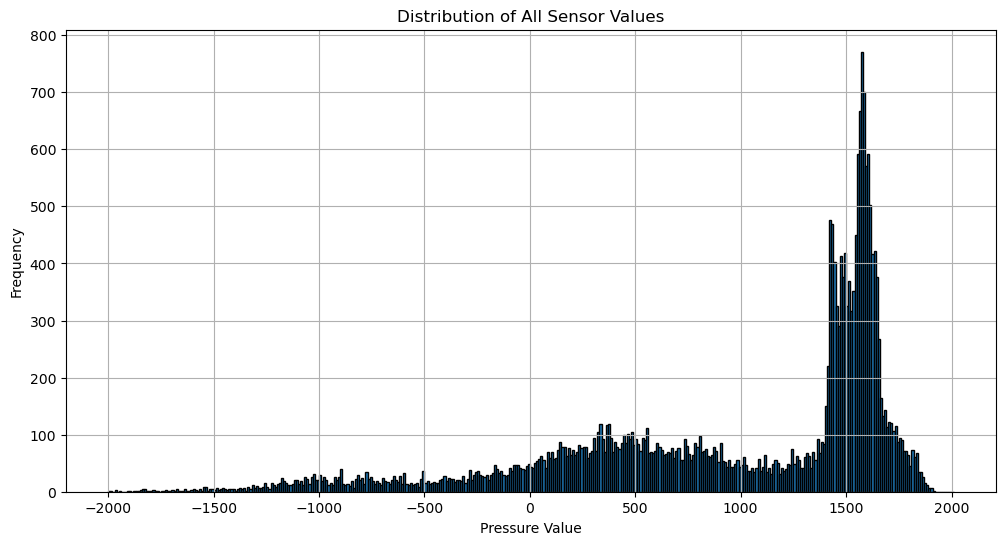

-4461.723435312963
17261.552413893754


In [6]:
# Visualize distribution with a histogram (code provided by ChatGPT)
sensor_data = pressure_train.iloc[:,1:]
all_values = sensor_data.values.flatten()
plt.figure(figsize=(12, 6))
plt.hist(all_values, bins = np.arange(-2000, all_values.max() + 100, 10), edgecolor='black')
plt.title('Distribution of All Sensor Values')
plt.xlabel('Pressure Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

print(np.mean(all_values))
print(np.std(all_values))


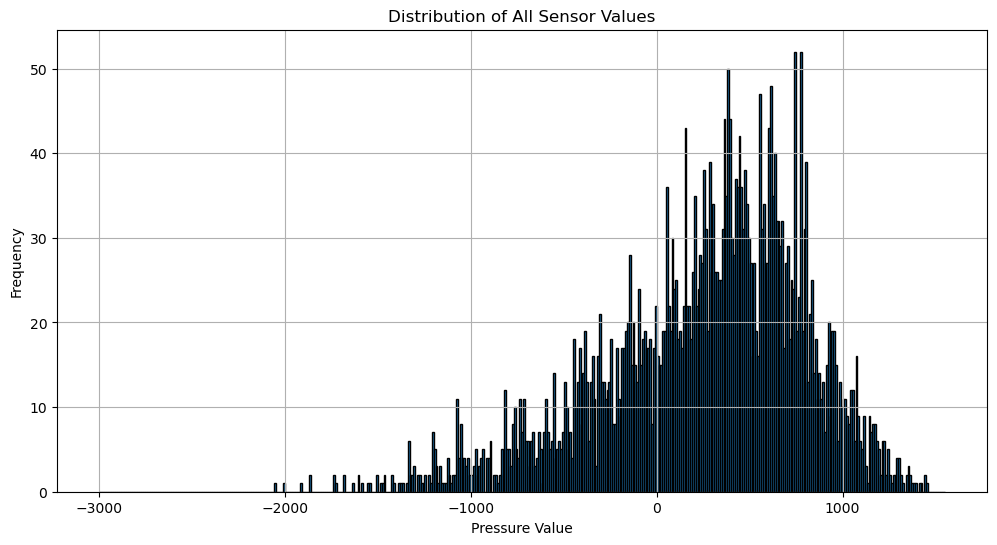

-6714.818665868153
18732.12920533961


In [7]:
# Visualize distribution with a histogram (code provided by ChatGPT)
sensor_data = pressure_pred.iloc[:,1:]
all_values = sensor_data.values.flatten()
plt.figure(figsize=(12, 6))
plt.hist(all_values, bins = np.arange(-3000, all_values.max() + 100, 10), edgecolor='black')
plt.title('Distribution of All Sensor Values')
plt.xlabel('Pressure Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

print(np.mean(all_values))
print(np.std(all_values))

We clearly have false measures in our data as there is no trend in those large negative values and a very small frequency. To fix this, we will apply a low filter at -1'500. Once we delete this data, we'll try not to delete the whole column/row as it would remove quite a lot of data. So we prefer to impute the missing data, we could use constant or mean imputation but we'll use KNN imputation to replace them, with 2 neighbors as it will more likely preserve the time continuation.  
<font color="red"> should we remove outliers from the test data ? It seems not very clever to try predicting false values...

0 columns in pressure_train are filled with NaN
99 columns in pressure_train are filled with NaN after clipping
22 columns in pressure_pred are filled with NaN after clipping


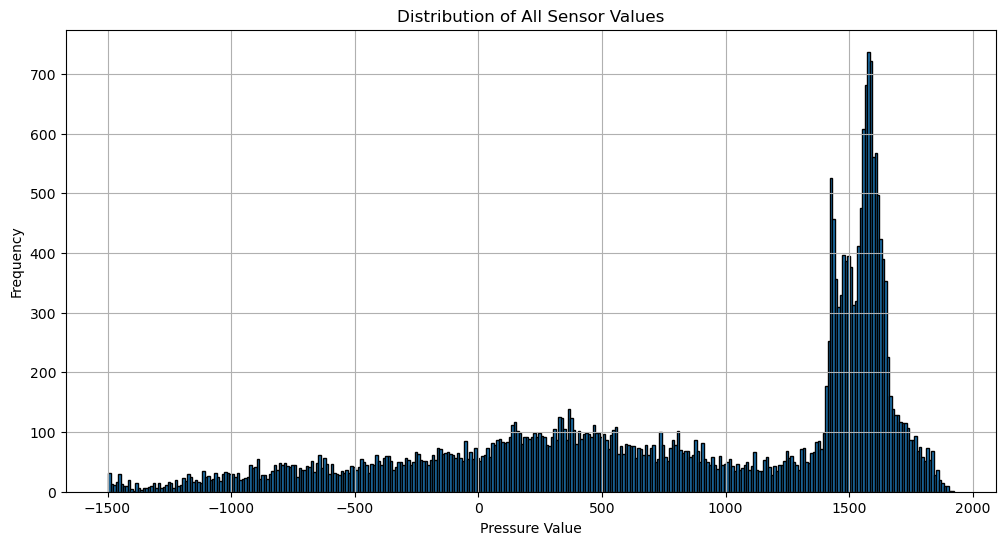

Mean: 831.6381444510338
SD: 845.3622410001435


In [8]:
## Checking how many columns are filled with NaN values
count = pressure_train.isnull().all().sum()
print(f'{count} columns in pressure_train are filled with NaN')

## clearing values below -1'500:
pressure_train.iloc[:,1:] = pressure_train.iloc[:,1:].mask(pressure_train.iloc[:,1:] <= -1500, np.nan) 
# pressure_train.iloc[:,1:] = pressure_train.iloc[:,1:].mask(pressure_train.iloc[:,1:] >= 1500, np.nan) 
pressure_pred.iloc[:,1:] = pressure_pred.iloc[:,1:].mask(pressure_pred.iloc[:,1:] <= -1500, np.nan)
# pressure_train.iloc[:,1:] = pressure_train.iloc[:,1:].mask(pressure_train.iloc[:,1:] >= 1500, np.nan) 

## Checking how many columns are filled with NaN values
count = pressure_train.isnull().all().sum()
print(f'{count} columns in pressure_train are filled with NaN after clipping')
count = pressure_pred.isnull().all().sum()
print(f'{count} columns in pressure_pred are filled with NaN after clipping')

## We fill empty columns with KNN, instead of dropping those sensors, we can add balanced data wich will hopefully act as regularization. 
if pressure_train.isna().all().any():
    pressure_train = func.fill_NaN_columns(
        K = 5,
        df = pressure_train,
        imputer = imputer,
        coords = coordinates_train
    )
if pressure_pred.isna().all().any():
    pressure_pred = func.fill_NaN_columns(
        K = 5,
        df = pressure_pred,
        imputer = imputer,
        coords = coordinates_pred
    )

## Imputing missing values (if there are some):
if pressure_train.isna().sum().sum() != 0: 
    pressure_train.interpolate(method='linear', axis=0, limit_direction='both', inplace=True)
if pressure_pred.isna().sum().sum() != 0:
    pressure_pred.interpolate(method='linear', axis=0, limit_direction='both', inplace=True)

# Visualize distribution with a histogram (code provided by ChatGPT)
sensor_data = pressure_train.iloc[:,1:]
all_values = sensor_data.values.flatten()
plt.figure(figsize=(12, 6))
plt.hist(all_values, bins = np.arange(all_values.min(), all_values.max() + 10, 10), edgecolor='black')
plt.title('Distribution of All Sensor Values')
plt.xlabel('Pressure Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## New distribution parameters:
print(f'Mean: {np.mean(all_values)}')
print(f'SD: {np.std(all_values)}')



#### **Humidity**

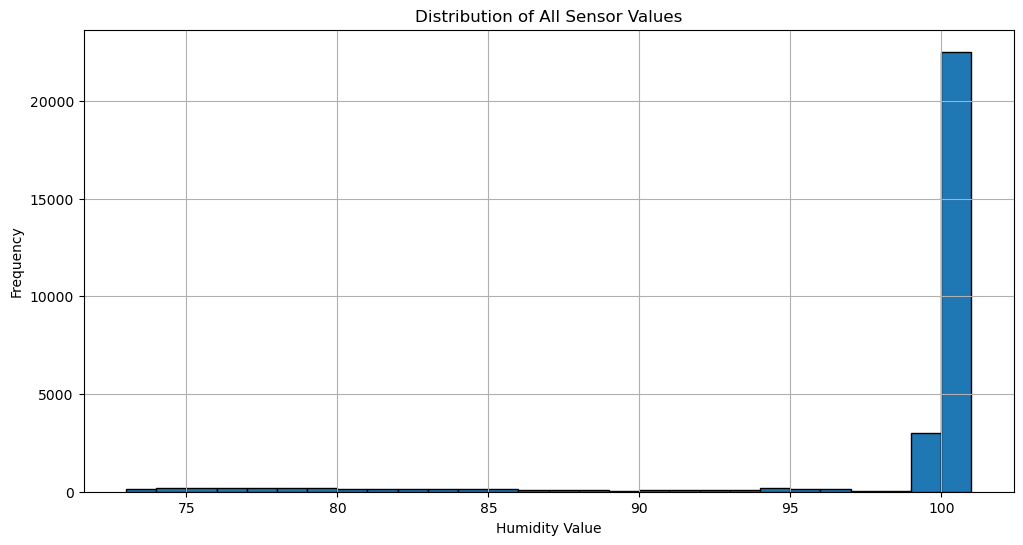

In [9]:
if humidity_train.isna().all().any():
    humidity_train = func.fill_NaN_columns(
        K = 5,
        df = humidity_train,
        imputer = imputer,
        coords = coordinates_train
    )

if humidity_pred.isna().all().any():
    humidity_pred = func.fill_NaN_columns(
        K = 5,
        df = humidity_pred,
        imputer = imputer,
        coords = coordinates_pred
    )


## Imputing the missing data
if humidity_train.isna().sum().sum() != 0: 
    humidity_train.interpolate(method='linear', axis=0, limit_direction='both', inplace=True)

if humidity_pred.isna().sum().sum() != 0: 
    humidity_pred.interpolate(method='linear', axis=0, limit_direction='both', inplace=True)
    

# Visualize distribution with a histogram (code provided by ChatGPT)
sensor_data = humidity_train.iloc[:,1:]
all_values = sensor_data.values.flatten()
plt.figure(figsize=(12, 6))
plt.hist(all_values, bins = np.arange(all_values.min(), all_values.max() + 1, 1), edgecolor='black')
plt.title('Distribution of All Sensor Values')
plt.xlabel('Humidity Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

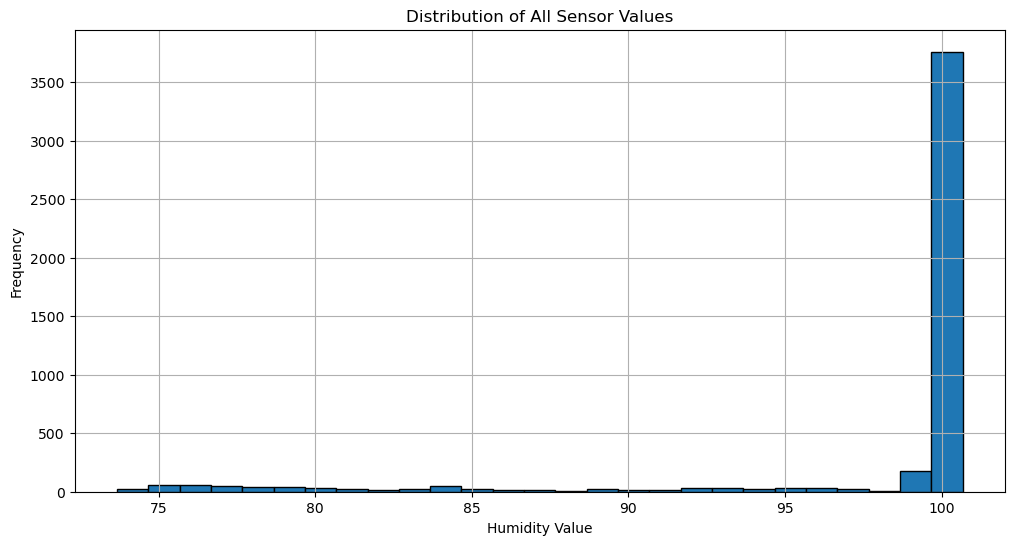

In [10]:
# Visualize distribution with a histogram (code provided by ChatGPT)
sensor_data = humidity_pred.iloc[:,1:]
all_values = sensor_data.values.flatten()
plt.figure(figsize=(12, 6))
plt.hist(all_values, bins = np.arange(all_values.min(), all_values.max() + 1, 1), edgecolor='black')
plt.title('Distribution of All Sensor Values')
plt.xlabel('Humidity Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


There are some values that appear rarely but they are very realistic so we decided not to clip them.

#### **Temperature**

Here we notice sudden spikes in the temperature going from about 20 to 2'000+ (the mineral would most likely melt at that temperature) and going back down to 20 a few days later. We can consider those value as measurement errors. We can replace those outliers by the mean of the 2 nearest neighbors if they are above a threshold of 60 (we can see it should work well by looking at the graph below), this is called value cliping.

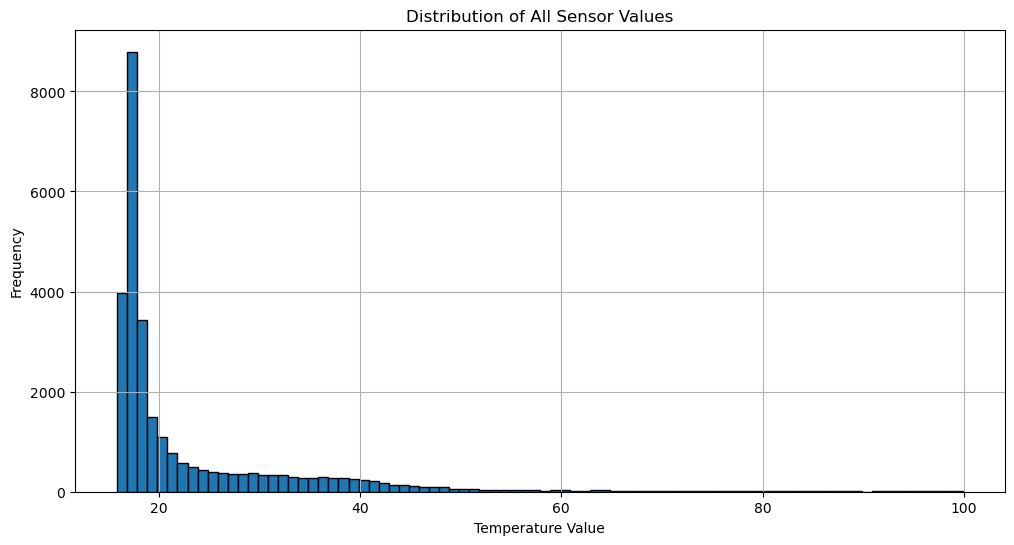

temperature_train shape: (32, 898)
empty columns: 0


In [11]:
## We impute a first time if needed so we can plot the distribution of values:
if temperature_train.isna().all().any():
    temperature_train = func.fill_NaN_columns(
        K = 5,
        df = temperature_train,
        imputer = imputer,
        coords = coordinates_train
    )

## We impute the missing data with the 2 nearest neighbors to view the distribution
## limit_direction='both' allows to impute data on the edges
if temperature_train.isna().any().any():
    temperature_train.interpolate(method='linear', axis=0, limit_direction='both', inplace=True)

# Visualize the distribution with a histogram (code provided by ChatGPT)
sensor_data = temperature_train.iloc[:,1:]
all_values = sensor_data.values.flatten()
plt.figure(figsize=(12, 6))
plt.hist(all_values, bins = np.arange(all_values.min(), 100, 1), edgecolor='black')
plt.title('Distribution of All Sensor Values')
plt.xlabel('Temperature Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## Applying the filter at 100°C, which seems reasonable:
temperature_train.iloc[:,1:] = temperature_train.iloc[:,1:].mask(temperature_train.iloc[:,1:] >= 100, np.nan) 

## Initial shape: 
print(f'temperature_train shape: {temperature_train.shape}')
print(f'empty columns: {temperature_train.isnull().all().sum()}')

## We impute the missing data with the 2 nearest neighbors as done with the pressure
if temperature_train.isna().any().any():
    temperature_train.interpolate(method='linear', axis=0, limit_direction='both', inplace=True)


### **Data augmentation** 

In [12]:
# new_times = np.array([1630, 1650, 1680, 1710, 1750, 1800, 1860, 1940, 2010, 2050, 2070, 2150, 2280, 2320, 2470, 2550, 2700, 2800, 2950, 3100, 3300, 3400, 3500, 3800, 4000, 5000, 5200, 5800, 6100, 6700, 6800])
new_times = np.array([1630, 1640,  1650, 1660, 1680, 1690, 1710, 1720, 1750, 1770, 1800, 1830, 1860, 1900, 1940, 1980, 2010, 2040, 2050, 2060, 2070, 2100, 2150, 2200, 2280, 2300,  2320, 2400, 2470, 2500, 2550, 2600, 2700, 2750, 2800, 2900, 2950, 3000, 3100, 3200, 3300, 3350, 3400, 3450, 3500, 3600, 3800, 3900, 4000, 4500, 5000, 5200, 5800, 6100, 6700, 6800])
time = np.union1d(time, new_times)

## Add new rows:  
pressure_train = pressure_train.set_index('M.Time[d]').reindex(time).interpolate(method='linear').reset_index()
humidity_train = humidity_train.set_index('M.Time[d]').reindex(time).interpolate(method='linear').reset_index()
temperature_train = temperature_train.set_index('M.Time[d]').reindex(time).interpolate(method='linear').reset_index()
## As the data has been cleared from outliers we can use the pandas interpolation without fearing new outliers (hopefully)

### **Feature engineering**

#### **Data normalization**

Data normalization is essential for a faster convergence of the descent methods and an appropriate penalization of the weights. We will use a z-score scaling technique as a min-max scaling would be scalled up by the few outliers left and concentrate the values too much. We'll then make sure the data is not too heavy-tailed for the scaling to work best.

In [13]:
## Mean and standard deviation are always computed on the training data
## axis = None computes the mean over the entire DataFrame with our current version of pandas: 2.0.3
## but it doesn't work with the std: 
#  https://stackoverflow.com/questions/25140998/pandas-compute-mean-or-std-standard-deviation-over-entire-dataframe

pressure_mean = pressure_train.iloc[:,1:].mean(axis=None) 
pressure_std = pressure_train.iloc[:,1:].values.std()

humidity_mean = humidity_train.iloc[:,1:].mean(axis=None) 
humidity_std = humidity_train.iloc[:,1:].values.std()

temperature_mean = temperature_train.iloc[:,1:].mean(axis=None)
temperature_std = temperature_train.iloc[:,1:].values.std()

coordinates_mean = coordinates_train[["x","y","z","r"]].mean(axis=0)
coordinates_std = coordinates_train[["x","y","z","r"]].std(axis=0)

# print(f'Mean pressure: {pressure_mean}')
# print(f'SD of pressure: {pressure_std}')

# print(f'Mean humidity: {humidity_mean}')
# print(f'SD of humidity: {humidity_std}')

# print(f'Mean temperature: {temperature_mean}')
# print(f'SD of temperature: {temperature_std}')

pressure_train.iloc[:,1:] -= pressure_mean
pressure_train.iloc[:,1:] /= pressure_std
pressure_pred.iloc[:,1:] -= pressure_mean
pressure_pred.iloc[:,1:] /= pressure_std

humidity_train.iloc[:,1:] -= humidity_mean
humidity_train.iloc[:,1:] /= humidity_std
humidity_pred.iloc[:,1:] -= humidity_mean
humidity_pred.iloc[:,1:] /= humidity_std

temperature_train.iloc[:,1:] -= temperature_mean
temperature_train.iloc[:,1:] /= temperature_std

coordinates_train[["x","y","z","r"]] -= coordinates_mean
coordinates_train[["x","y","z","r"]] /= coordinates_std
coordinates_pred[["x","y","z","r"]] -= coordinates_mean
coordinates_pred[["x","y","z","r"]] /= coordinates_std

## Check that the values now follow a normal distribution : 
## (the test sets will be off obviously)
assert np.isclose(pressure_train.iloc[:,1:].mean(axis=None), 0)
assert np.isclose(pressure_train.iloc[:,1:].values.std(), 1)

assert np.isclose(humidity_train.iloc[:,1:].mean(axis=None), 0)
assert np.isclose(humidity_train.iloc[:,1:].values.std(), 1)

assert np.isclose(temperature_train.iloc[:,1:].mean(axis=None), 0)
assert np.isclose(temperature_train.iloc[:,1:].values.std(), 1)

assert np.allclose(coordinates_train[["x","y","z","r"]].mean(axis=0), 0)
assert np.allclose(coordinates_train[["x","y","z","r"]].std(axis=0), 1)



Let's visualize our data before making it into numpy arrays :

In [14]:
# display(pressure_train.head(5))
# display(humidity_train.head(5))
# display(coordinates_train.head(5))
# display(temperature_train.head(5))

print(f"Pressure's shape: {pressure_train.shape}")
print(f"Humidity's shape: {humidity_train.shape}")
print(f"Coordinates' shape: {coordinates_train.shape}")
print(f"Temperature's shape: {temperature_train.shape}")

## Verify that we no longer have missing values: 
assert pressure_train.isnull().any().sum() == 0
assert pressure_pred.isnull().any().sum() == 0
assert humidity_train.isnull().any().sum() == 0
assert humidity_pred.isnull().any().sum() == 0
assert coordinates_train.isnull().any().sum() == 0
assert coordinates_pred.isnull().any().sum() == 0
assert temperature_train.isnull().any().sum() == 0

Pressure's shape: (86, 898)
Humidity's shape: (86, 898)
Coordinates' shape: (897, 11)
Temperature's shape: (86, 898)


##### **Visualizing the data**

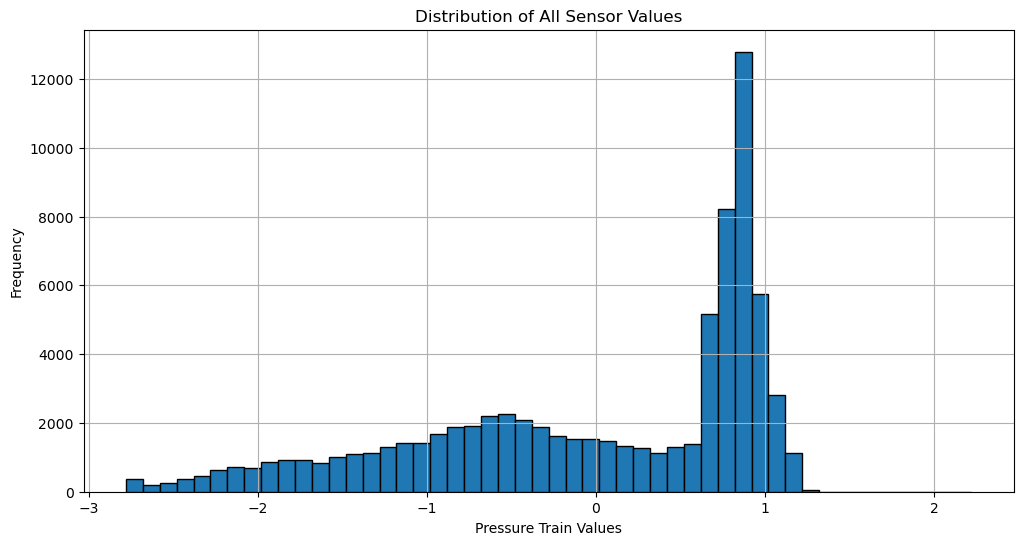

In [15]:
# Visualize distribution with a histogram again(code provided by ChatGPT)
sensor_data = pressure_train.iloc[:,1:]
all_values = sensor_data.values.flatten()
plt.figure(figsize=(12, 6))
plt.hist(all_values, bins = np.arange(all_values.min(), all_values.max() + 1, 0.1), edgecolor='black')
plt.title('Distribution of All Sensor Values')
plt.xlabel('Pressure Train Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

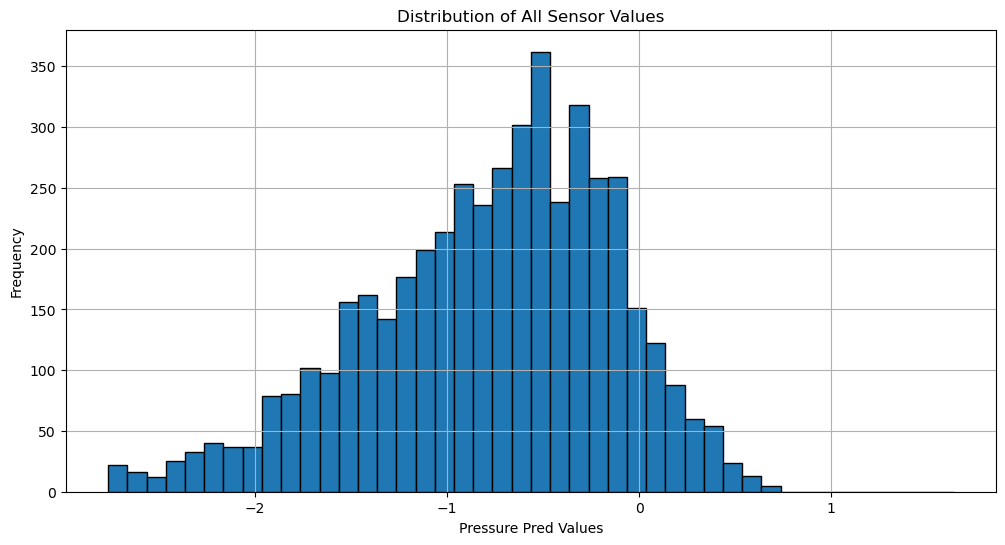

In [16]:
sensor_data = pressure_pred.iloc[:,1:]
all_values = sensor_data.values.flatten()
plt.figure(figsize=(12, 6))
plt.hist(all_values, bins = np.arange(all_values.min(), all_values.max() + 1, 0.1), edgecolor='black')
plt.title('Distribution of All Sensor Values')
plt.xlabel('Pressure Pred Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

<font color='red'> The distributions are very different and it might explain why the model performs very well on the validation set but not on the test set (Kaggle score): This is called distribution mismatch. Maybe cloning (in time) values 

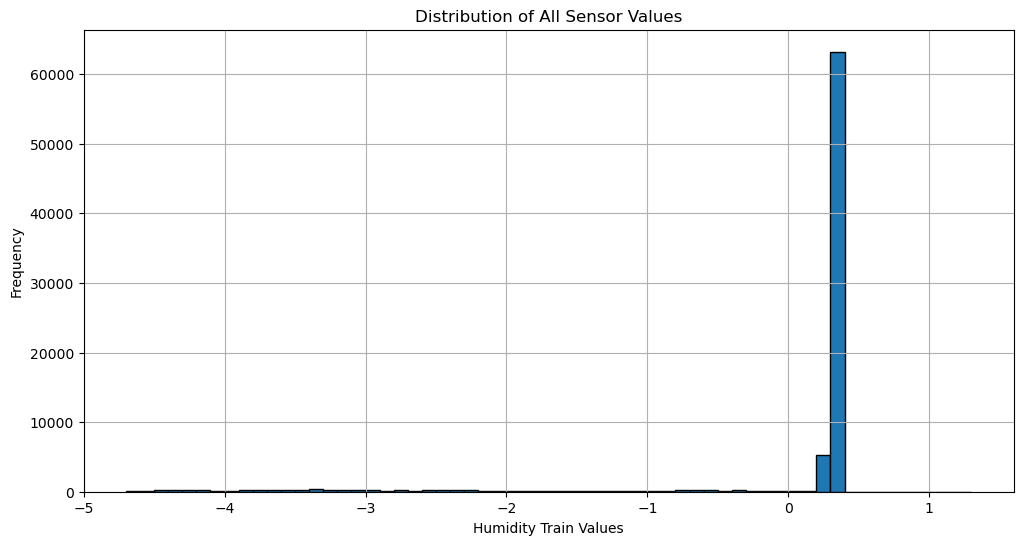

In [17]:
# Visualize the distribution with a histogram (code provided by ChatGPT)
sensor_data = humidity_train.iloc[:,1:]
all_values = sensor_data.values.flatten()
plt.figure(figsize=(12, 6))
plt.hist(all_values, bins = np.arange(all_values.min(), all_values.max() + 1, 0.1), edgecolor='black')
plt.title('Distribution of All Sensor Values')
plt.xlabel('Humidity Train Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

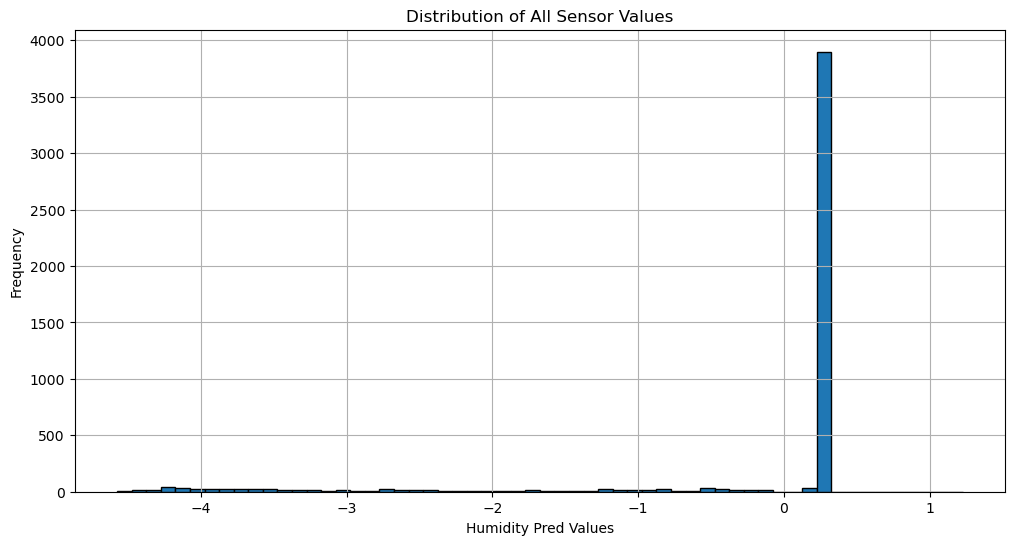

In [18]:
# Visualize the distribution with a histogram (code provided by ChatGPT)
sensor_data = humidity_pred.iloc[:,1:]
all_values = sensor_data.values.flatten()
plt.figure(figsize=(12, 6))
plt.hist(all_values, bins = np.arange(all_values.min(), all_values.max() + 1, 0.1), edgecolor='black')
plt.title('Distribution of All Sensor Values')
plt.xlabel('Humidity Pred Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

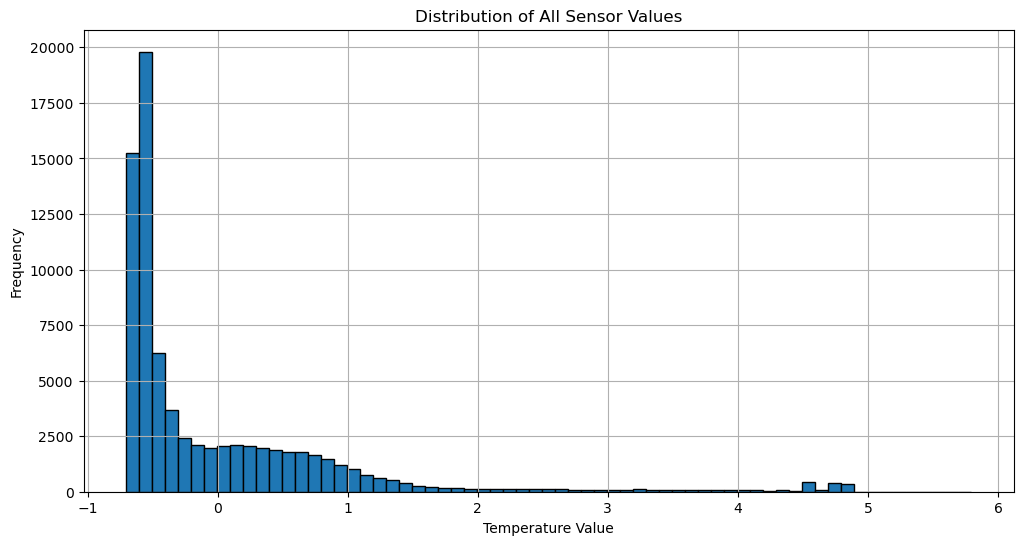

In [19]:
# Visualize the distribution with a histogram (code provided by ChatGPT)
sensor_data = temperature_train.iloc[:,1:]
all_values = sensor_data.values.flatten()
plt.figure(figsize=(12, 6))
plt.hist(all_values, bins = np.arange(all_values.min(), all_values.max() + 1, 0.1), edgecolor='black')
plt.title('Distribution of All Sensor Values')
plt.xlabel('Temperature Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


Text(0.5, 0.92, '3D Temperature Distribution')

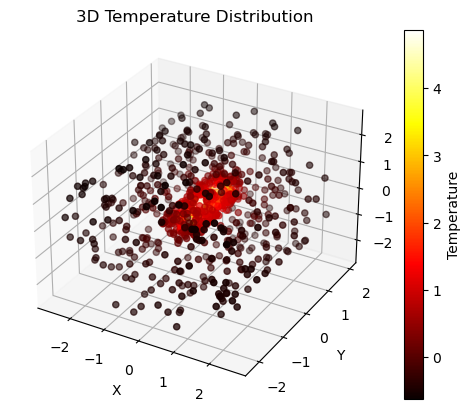

In [20]:
T = temperature_train.iloc[-4,1:].to_numpy()
x = coordinates_train["x"].to_numpy()
y = coordinates_train["y"].to_numpy()
z = coordinates_train["z"].to_numpy()

# Create 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(x, y, z, c=T, cmap='hot', marker='o')

# Add colorbar to show temperature scale
plt.colorbar(sc, label='Temperature')

# Add labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Temperature Distribution')


All the chapes are matching, we can assume that indices match between each DataFrame

#### **Splitting data**  

We will first split the data into 3 sets with an arbitrary split: 
- Train set
- Validation set 
- Test set  

Later we'll implement a cross-validation for a better training.

In [21]:
## The idea is to have a DataFrame for each time stamp as follows: 
## And then stack them vertically in one array, with the rows shuffled so hopefully we have representative data in each fold.

#           | pressure | humidity | x | y | z | r |  materials... | t |
# ----------+----------+----------+---+---+---+---+---------------+---+
# N_1       |          |          |   |   |   |   |               |   |
# ...       |          |          |   |   |   |   |               |   |
# N_900     |          |          |   |   |   |   |               |   |

X, y = func.get_train_data(
    pressure_train,
    humidity_train,
    temperature_train,
    coordinates_train,
    time_mean,
    time_std
)

## defining the number of features (useful later for the NN):
n_samples, n_features = X.shape
print(f"Size of X: {X.shape}")

Size of X: (77142, 13)


### **Creating the model**  

For this project we will first try to use a vanilla neural network

#### **The model**

In [22]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error

## Define the split ratio: 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=random_state)

## Set the labels as a 1D array
y_train = y_train.ravel()
y_test = y_test.ravel()
print(f"Training Set Size: {X_train.shape}")
print(f"Test Set Size: {X_test.shape}")

model = GradientBoostingRegressor(random_state=random_state, n_iter_no_change=1)

Training Set Size: (65570, 13)
Test Set Size: (11572, 13)


### **Validation**

In [23]:

def validate(
        model: torch.nn.Module, 
        loss_fn: torch.nn.Module, 
        X_val: np.ndarray, 
        y_val: np.ndarray,

) -> float:
    """Validate the model and return the average loss."""

    # Initialize metrics for loss:
    loss_metric = metrics.LossMetric()
    loss_metric.reset()

    # Set the model to evaluation mode
    model.eval()  

    with torch.no_grad():  # Disable gradient calculation for validation

        X = X_val
        y = y_val

        assert X.shape[0] == y.shape[0], f"Size mismatch between X and y: {X.shape[0]}, {y.shape[0]}"

        for i in range(X.shape[0]):
            data = torch.from_numpy(np.array(X[i,:], dtype=np.float32)).unsqueeze(0).to(device) 
            target = torch.from_numpy(np.array(y[i], dtype=np.float32)).view(1, 1).to(device)

            # Forward pass
            out = model.forward(data)
            loss = loss_fn(out, target)
            
            # Update metrics & progress bar
            ## As the batch size in the validation is 1, it can be more precise than the training and have a better score
            loss_metric.update(loss.item(), batch_size=1)
                
        final_loss = loss_metric.compute()
        loss_metric.reset()
        return final_loss

### **Training**
  
Each timestamp represents an epoch: data of the ~900 sensors.

In [ ]:
## We will use a random search for this and keep track of the results in a csv.
param_distributions = {
    'n_estimators': list(range(50,601,50)),
    'max_depth': list(range(4,6,1)), ## we should not need a high depth as we have few features only
    'learning_rate': [0.01, 0.03, 0.05, 0.07, 0.1],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1]
}
## A total of ~17k possibilities initially
## removed possibilities: 
# lr =          0.001
# max_depth =   2, 3, 6, 7, 8, 9

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    n_iter=40,  # expect ~2 min per iteration
    cv=6,       # cross-validation folds
    scoring='neg_mean_squared_error',
    n_jobs=-1   # use all processors
)

random_search.fit(X_train, y_train)
print("Best parameters found: ", random_search.best_params_)
print("Best cross-validation accuracy: ", random_search.best_score_)



Best parameters found:  {'subsample': 0.5, 'n_estimators': 250, 'max_depth': 8, 'learning_rate': 0.1}
Best cross-validation accuracy:  -0.0014321724954466097


In [25]:
## saving the results

import os
csv_path = 'results\\XGboost_RS_results.csv'
write_header = not os.path.exists(csv_path)

results = random_search.cv_results_
results = pd.DataFrame(results)
columns_to_save = ['params', 'mean_test_score', 'std_test_score']
results[columns_to_save].to_csv(csv_path, index=False, mode='a', header=write_header)

### **Testing**

In [26]:
print("Test accuracy: ",np.round(random_search.score(X_test, y_test), 3))

Test accuracy:  -0.001


### **Making a submission**

In [27]:
X_t_pred = {}

# Update sensor_IDs for the prediction data (N_>900)
sensor_IDs = pressure_pred.columns[1:]
pred = pd.DataFrame(data=sensor_IDs, columns=["id"])

for i, t in enumerate(pressure_pred['M.Time[d]']): 
    # Extract pressure and humidity data at the specific time `t`
    P = pressure_pred.iloc[i, 1:]
    H = humidity_pred.iloc[i, 1:]

    # Reshape to (n_sensors, 1) to maintain consistency
    P = np.reshape(P.values, (P.shape[0], 1))
    H = np.reshape(H.values, (H.shape[0], 1))

    # Extract coordinates and material features
    coords = coordinates_pred.iloc[:, 1:].to_numpy()

    # Combine all features including normalized time
    X = np.concatenate([P, H, coords, np.ones((P.shape[0], 1)) * (t - time_mean) / time_std], axis=1)
    
    # Store the data for the given timestamp
    X_t_pred[t] = X

# Iterate through each timestamp to predict and store the results
for t in pressure_pred["M.Time[d]"]:
    X = X_t_pred[t]

    # Predict using the trained Gradient Boosting Regressor model
    y_pred = random_search.predict(X)

    # Revert normalization
    y_pred = (y_pred * temperature_std) + temperature_mean

    # Add predictions to the dataframe
    pred[str(int(t))] = y_pred

# Save predictions to CSV
pred.to_csv("data\\submission.csv", index=False)

print("Submission file saved as 'submission.csv'")

Submission file saved as 'submission.csv'


145


Text(0.5, 0.92, '3D Temperature Distribution')

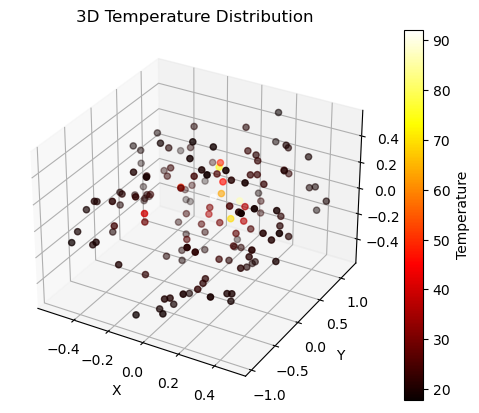

In [28]:
print(len(pred))
T = pred.iloc[:, -20].to_numpy()
x = coordinates_pred["x"].to_numpy()
y = coordinates_pred["y"].to_numpy()
z = coordinates_pred["z"].to_numpy()

# Create 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(x, y, z, c=T, cmap='hot', marker='o')

# Add colorbar to show temperature scale
plt.colorbar(sc, label='Temperature')

# Add labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Temperature Distribution')

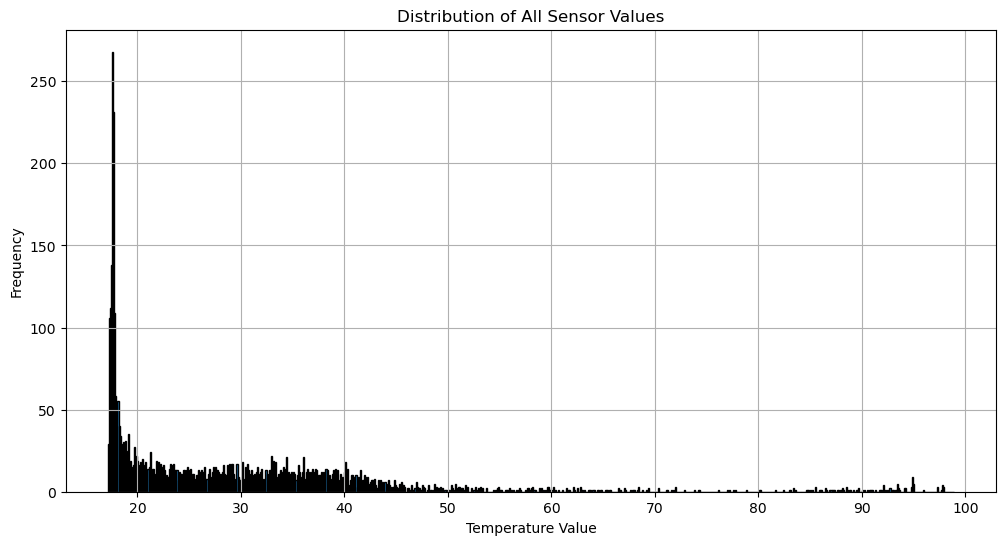

In [29]:
# Visualize the distribution with a histogram (code provided by ChatGPT)
sensor_data = pred.iloc[:,1:]
all_values = sensor_data.values.flatten()
plt.figure(figsize=(12, 6))
plt.hist(all_values, bins = np.arange(all_values.min(), all_values.max() + 1, 0.1), edgecolor='black')
plt.title('Distribution of All Sensor Values')
plt.xlabel('Temperature Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [ ]:
best_results = pd.read_csv("results\\XGboost_RS_results.csv")
best_results.sort_values(by='std_test_score', axis = 0, ascending=True, inplace=True)
display(best_results.head(5))

,params,mean_test_score,std_test_score,kaggle_score
39,"{'subsample': 0.7, 'n_estimators': 550, 'max_d...",-0.001368,0.000051,NaN
58,"{'subsample': 0.9, 'n_estimators': 500, 'max_d...",-0.001688,0.000065,NaN
18,"{'subsample': 0.7, 'n_estimators': 250, 'max_d...",-0.001175,0.000065,NaN
49,"{'subsample': 1, 'n_estimators': 450, 'max_dep...",-0.001782,0.000074,NaN
42,"{'subsample': 0.7, 'n_estimators': 350, 'max_d...",-0.002429,0.000083,NaN


In [ ]:
{'subsample': 1, 'n_estimators': 450, 'max_depth': 9, 'learning_rate': 0.05}
{'subsample': 0.7, 'n_estimators': 350, 'max_depth': 9, 'learning_rate': 0.03}